# Visualisation of the trials

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import json
from sympy import sympify, latex

from new_analysis import eq_algo_summary, get_job_status
from constants import TEMP_DIR, ALGORITHMS

In [2]:
#import scienceplots
#plt.style.use(['science', 'notebook'])
plt.rcParams['axes.linewidth'] = 2
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
plt.rc('axes',labelsize=12)
plt.rc('legend',fontsize=12)

## Read the data

In [3]:
def read_data(read_from_file=True, not_found=np.nan):
    if read_from_file:
        with open(TEMP_DIR / "eq_algo_summary.json", "r") as f:
            summary_dict = json.load(f)
    else:
        get_job_status(state="finished", new_status=True)
        summary_dict = eq_algo_summary()

    # create a dataframe from the summary dictionary
    eq_names = [s.split(" ")[1] for s in summary_dict.keys()]
    summary_df = pd.DataFrame(columns=ALGORITHMS, index=eq_names)
    summary_df.index.name = "Equation"

    for eq in summary_dict:
        for algo in summary_dict[eq]:
            last_n = np.array(summary_dict[eq][algo]["last_n"], dtype=float)
            # replace  499 with nan
            last_n[last_n == 499] = not_found
            summary_df.loc[str(eq.split(" ")[1]), algo] = last_n


    # Read the CSV file into a dictionary
    equations_dict = pd.read_csv('feynman.csv', index_col='Filename')['Formula'].to_dict()
    # Add the equations to the dataframe
    summary_df['formula'] = summary_df.index.map(equations_dict)
    return summary_df

## Visualise the data

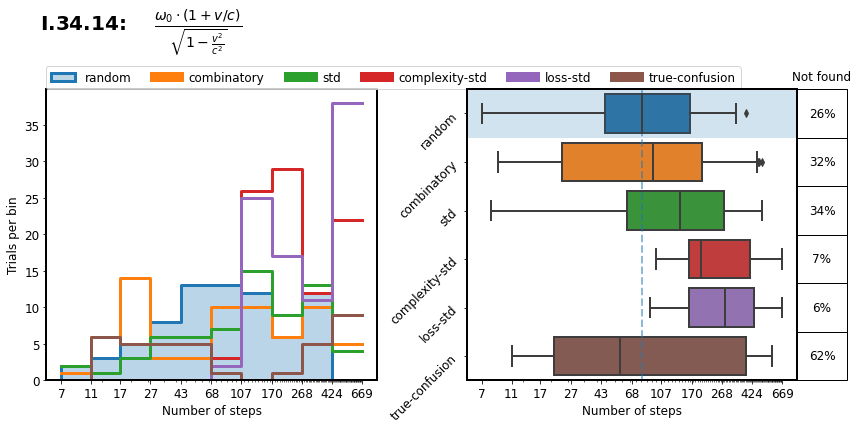

Plots saved in "plots.pdf"


In [4]:
# Set to True to save the plots as a pdf
save_as_pdf = False

# Define the number of bins
num_bins = 10
offset = 10

# copy the dataframe
summary_df = read_data(read_from_file=True, not_found=np.nan)
# add a column with the equation latex formulas from the feynman.csv file. use sympy to convert the string to latex
# load the feynman.csv file



def plot_hist_and_boxplot(pdf=None, log_scale=False):
    """Plot histogram with KDE for each equation and algorithm on the left, and a boxplot on the right"""

    for j, equation in enumerate(summary_df.index):
        # DEBUG
        if j > 8:
            break
        if j < 8:
            continue

        # Find the bin edges with the highest count
        max_bin_edges = None
        max_bin_count = 0

        _min = 500
        _max = 0

        for column in summary_df.columns[:-1]: # skip the last column, which is the formula
            # # account for log scale
            # bin_edges = np.histogram_bin_edges(summary_df.loc[equation, column])
            # print(bin_edges, len(bin_edges))
            # bin_counts = np.histogram(summary_df.loc[equation, column], bins=bin_edges)[0]
            # # Find the bin edges with the highest count
            # max_count = np.max(bin_counts)
            # print(max_count)
            # if max_count > max_bin_count:
            #     max_bin_count = max_count
            #     max_bin_edges = bin_edges
            # find min and max of the data
            _min = min(_min, np.nanmin(summary_df.loc[equation, column]))
            _max = max(_max, np.nanmax(summary_df.loc[equation, column]))
        
        # create bin edges with log scale
        if log_scale:
            bin_edges = np.logspace(np.log10(_min), np.log10(_max), num_bins+1, dtype=int)
        else:
            bin_edges = np.linspace(_min, _max, num_bins+1, dtype=int)
        
            
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        palette = sns.color_palette("tab10", len(ALGORITHMS))
        try:
            for i, column in enumerate(summary_df.columns[:-1]):
                # Use `bins` parameter to set the number of bins
                sns.histplot(summary_df.loc[equation, column], log_scale=False, bins=bin_edges, ax=ax[0], label=column, fill=(column=="random"), linewidth=3, element="step", color=palette[i], alpha=(0.3 if column=="random" else 1))
            # Plot the boxplot with the algorithm names on the x-axis
            sns.boxplot(data=summary_df.loc[equation].iloc[:-1], orient="h", ax=ax[1], showfliers=True, linewidth=2, palette=palette)
            # add a line for the mean of the random algorithm
            # get color of the random algorithm (seaborn)
            random_color = sns.color_palette()[0]
            ax[1].axvline(np.nanmedian(summary_df.loc[equation, 'random']), color=random_color, linestyle='--', linewidth=2, alpha=0.5)
            # add a background color to the random algorithm
            ax[1].axhspan(-0.5, 0.5, facecolor=random_color, alpha=0.2)
            
            
        except Exception as e:
            print(f"Could not plot {equation}")
            print(e)
            continue
        # Add x-ticks to the boxplot
        ax[1].set_yticklabels(ALGORITHMS, rotation=45, horizontalalignment='right')

        #ax[0].set_title("Histogram")
        #ax[1].set_title("Boxplot")
        ax[0].set_xlabel("Number of steps")
        ax[0].set_ylabel("Trials per bin")
        ax[1].set_xlabel("Number of steps")

        #change the x-axis of the ax[0] to semilog
        if log_scale:
            ax[0].set_xscale('log')
            ax[1].set_xscale('log')
            # replace the x-ticks with the bin edges
            # make minor ticks between the bin edges
            minor_bin_edges = np.linspace(_min, _max, num_bins*10+1, dtype=int)
            ax[0].set_xticks(minor_bin_edges, minor=True)
            ax[0].set_xticklabels([], minor=True)
            ax[1].set_xticks(minor_bin_edges, minor=True)
            ax[1].set_xticklabels([], minor=True)
            
            
            ax[0].set_xticks(bin_edges, minor=False)
            ax[0].set_xticklabels(bin_edges, minor=False)
            ax[1].set_xticks(bin_edges, minor=False)
            ax[1].set_xticklabels(bin_edges, minor=False)


        # add a table to the plot with the number of nan values for each algorithm
        # create a table with the number of nan values for each algorithm
        nan_table = pd.DataFrame(index=ALGORITHMS, columns=["Not found"])#
        for column in summary_df.columns[:-1]:
            # in percentage
            nan_table.loc[column, "Not found"] = str(int(np.sum(np.isnan(summary_df.loc[equation, column])) / len(summary_df.loc[equation, column]) * 100)) + "%"

    
        # create the table
        table = ax[1].table(cellText=nan_table.values, loc='right', bbox=[1.0, 0.0, 0.15, 1.0], cellLoc='center')
        # set the font size of the table
        table.set_fontsize(12)
        # add text above the table
        ax[1].text(1.075, 1.02, "Not found", fontsize=12, transform=ax[1].transAxes, ha='center', va='bottom')
        
        fig.suptitle(equation+":    "+latex(sympify(summary_df.loc[equation, 'formula']), mul_symbol="dot", mode="inline", fold_frac_powers=True, parenthesize_super=True), fontsize=20, weight="bold", ha="left", x=0.05, y=0.98)
        # add padding below the title
        fig.tight_layout()
        # make the legend below the plot
        leg = ax[0].legend(loc='upper center', bbox_to_anchor=(1.05, 1.10), ncol=6, fancybox=True)
        for line in leg.get_lines():
            line.set_linewidth(10.0)
        
        if pdf:
            pdf.savefig(fig)
        else:
            plt.show()
        plt.close(fig)

        

    print('Plots saved in "plots.pdf"')


if save_as_pdf:
    with PdfPages(TEMP_DIR / 'plots.pdf') as pdf:
        plot_hist_and_boxplot(pdf=pdf, log_scale=True)
else:
    plot_hist_and_boxplot(log_scale=True)

In [5]:
# ridge plot
for equation in summary_df.index:
    max_bin_edges = None
    max_bin_count = 0
    for column in summary_df.columns:
        bin_edges = np.histogram_bin_edges(summary_df.loc[equation, column], bins=15)
        bin_counts = np.histogram(summary_df.loc[equation, column], bins=bin_edges)[0]
        # Find the bin edges with the highest count
        max_count = np.max(bin_counts)
        if max_count > max_bin_count:
            max_bin_count = max_count
            max_bin_edges = bin_edges
    df = pd.DataFrame(columns=["Algorithm", "Steps"])
    for column in summary_df.columns:
        df.loc[len(df)] = [column, summary_df.loc[equation, column].tolist()]
    df = df.explode("Steps")
    palette = sns.color_palette("Set2", len(ALGORITHMS))
    g = sns.FacetGrid(df, row="Algorithm", aspect=8, height=1.2, palette=palette, hue="Algorithm")
    g.map_dataframe(sns.histplot, x="Steps", bins=max_bin_edges)
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .5, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
    g.map(label, "Algorithm")
    g.set_titles("")
    g.set(yticks=[], xlabel="Number of steps")
    g.despine(left=True)
    # remove y label
    g.set(ylabel="")
    plt.suptitle('Steps to convergence for each algorithm', y=0.98)
    plt.show()
    break # DEBUG
    

UFuncTypeError: ufunc 'minimum' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> None

## Aggregated plot

In [5]:
# plot all the equations in one boxplot.
# create a dataframe with the median number of steps for each equation and algorithm
# add to ALGORITHMS the column "not_found" which contains the number of nan values for each algorithm
summary_df = read_data(read_from_file=True, not_found=np.nan)
median_df = pd.DataFrame(index=summary_df.index, columns=list(ALGORITHMS).append([f"{algorithm}_not_found" for algorithm in ALGORITHMS]), dtype=float)
for equation in summary_df.index:
    for column in summary_df.columns[:-1]:
        median_df.loc[equation, column] = np.nanmedian(summary_df.loc[equation, column])
        # count the number of nan values
        median_df.loc[equation, column+"_not_found"] = np.sum(np.isnan(summary_df.loc[equation, column]))


/beegfs/desy/user/bornemaf/conda/envs/PySR/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


/tmp/ipykernel_3939/3235461057.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  random_hist = sns.histplot(data=algorithms_df['random'], ax=ax[1], palette=sns.color_palette(), linewidth=2, element="step", fill=True, bins=bins, alpha=0.3)
/tmp/ipykernel_3939/3235461057.py:10: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  algo_hist = sns.histplot(data=algorithms_df.loc[:, algorithms_df.columns != 'random'], ax=ax[1], palette=sns.color_palette()[1:], linewidth=2, element="step", fill=False, bins=bins)


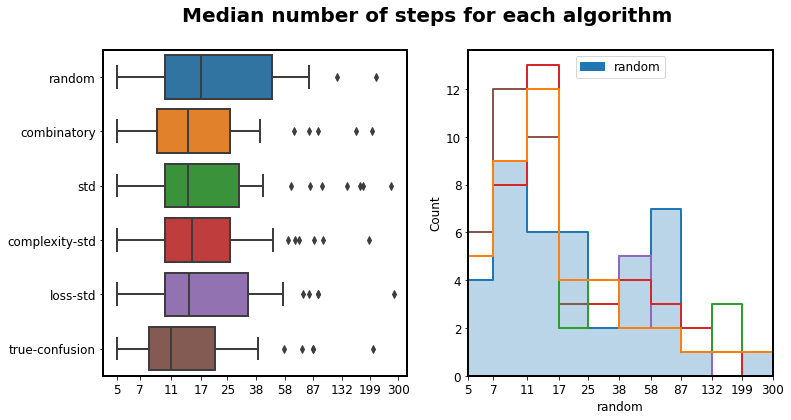

In [8]:
# make a boxplot and histogram for each algorithm
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

num = 10
bins = np.logspace(np.log10(5), np.log10(300), num+1, dtype=int)

algorithms_df = median_df[["random", "combinatory", "std", "complexity-std", "loss-std", "true-confusion"]]
sns.boxplot(data=algorithms_df, ax=ax[0], palette=sns.color_palette(), linewidth=2, orient="h")
random_hist = sns.histplot(data=algorithms_df['random'], ax=ax[1], palette=sns.color_palette(), linewidth=2, element="step", fill=True, bins=bins, alpha=0.3)
algo_hist = sns.histplot(data=algorithms_df.loc[:, algorithms_df.columns != 'random'], ax=ax[1], palette=sns.color_palette()[1:], linewidth=2, element="step", fill=False, bins=bins)
# log scale x-axis
ax[0].set_xscale('log')
ax[1].set_xscale('log')

# get the first and last bin edges to set the x-axis limits
data_random = random_hist.get_lines()[0].get_data()[0]
data_algo = algo_hist.get_lines()[0].get_data()[0]
data = np.concatenate((data_random, data_algo))
first_bin_edge = data[0]
last_bin_edge = data[-1]



# Set x-axis limits to include the left and right borders
plt.xlim(left=first_bin_edge, right=last_bin_edge)

# change the x-ticks to log scale

ax[0].set_xticks(bins, minor=False)
ax[0].set_xticks([], minor=True)
ax[0].set_xticklabels(bins, minor=False)
ax[1].set_xticks(bins, minor=False)
ax[1].set_xticks([], minor=True)
ax[1].set_xticklabels(bins, minor=False)

# add the random histogram to the legend
handles, labels = ax[1].get_legend_handles_labels()
handles.append(matplotlib.patches.Patch(color=sns.color_palette()[0], label="random"))
ax[1].legend(handles=handles, loc='upper center')

# title
fig.suptitle("Median number of steps for each algorithm", fontsize=20, weight="bold")

# show plots
plt.show()

## Aggregated difference plot

In [68]:
def median_difference(not_found_num=650):
    summary_df = read_data(read_from_file=True, not_found=not_found_num)
    median_difference_df = pd.DataFrame(index=summary_df.index, columns=list(ALGORITHMS[1:]).append([f"{algorithm}_not_found" for algorithm in ALGORITHMS[1:]]), dtype=float)
    for equation in summary_df.index:
        random_median = np.nanmedian(summary_df.loc[equation, "random"])
        for column in summary_df.columns[1:-1]:
            median_difference_df.loc[equation, column] = random_median - np.nanmedian(summary_df.loc[equation, column])
            # count the number of nan values
            median_difference_df.loc[equation, column+"_not_found"] = np.sum(np.isnan(summary_df.loc[equation, column]))
    # remove the rows with nan values
    median_difference_df = median_difference_df.dropna()
    return median_difference_df

def linspace_with_zero(xmin, xmax, num, log=False):
    half_num = num // 2  # Number of elements on each side of zero
    step = (xmax - xmin) / (num - 1)  # Step size between elements
    if not log:
        neg_values = np.linspace(xmin, 0.0, half_num, endpoint=False, dtype=int)  # Values on the negative side
        pos_values = np.linspace(0.0, xmax, num - half_num, dtype=int)  # Values on the positive side
    else:
        pos_values = np.logspace(0.0, np.log10(xmax), num - half_num, dtype=int)
        neg_values = -np.logspace(0.0, np.log10(-xmin), half_num, endpoint=True, dtype=int)
        # reverse the negative values
        neg_values = neg_values[::-1]
    return np.concatenate((neg_values, pos_values))

/beegfs/desy/user/bornemaf/conda/envs/PySR/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


True
combinatory mu: 20.2, std: 89.25208681033739
std mu: 11.4875, std: 92.28065124255463
complexity-std mu: 24.1, std: 80.4423862152286
loss-std mu: 20.3875, std: 86.85465499183104
true-confusion mu: 12.5375, std: 122.85476117656165


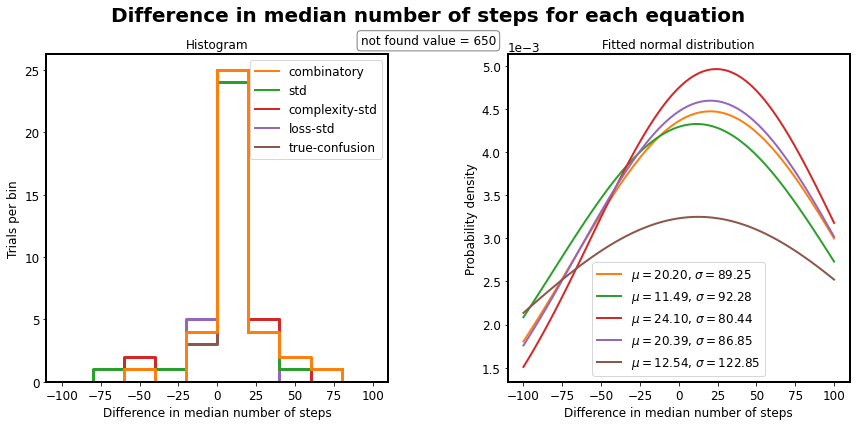

In [51]:

not_found = 650
median_difference_df = median_difference(not_found_num = not_found)

# plot the dataframe in a histogram around 0
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

num = 10
xmin, xmax = -100, 100
bins = linspace_with_zero(xmin, xmax, num+1)
palette = sns.color_palette()[1:6]

algorithms_df = median_difference_df[["combinatory", "std", "complexity-std", "loss-std", "true-confusion"]]
sns.histplot(data=algorithms_df, ax=ax[0], palette=palette, linewidth=3, element="step", fill=False, bins=bins, legend=True)

for i,algo in enumerate(ALGORITHMS[1:]):
    # plot the median
    median = np.nanmean(median_difference_df[algo])
    #print(f"{algo} median: {median}")
    #ax[0].axvline(median, color=palette[i], linestyle='--', linewidth=2)


# fit normal distribution to every algorithm
from scipy.stats import norm
for i, algo in enumerate(ALGORITHMS[1:]):
    # fit a normal distribution to the data
    mu, std = norm.fit(median_difference_df[algo])
    print(f"{algo} mu: {mu}, std: {std}")
    # plot the pdf
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax[1].plot(x, p, linewidth=2, label=f"$\\mu = {mu:.2f}$, $\\sigma = {std:.2f}$", color=palette[i])

# add a text box with the mean and std of each algorithm
# textstr = ""

# for algo in ALGORITHMS[1:]:
#     textstr += f"{algo} mean: {np.nanmean(median_difference_df[algo]):.2f}, std: {np.nanstd(median_difference_df[algo]):.2f}"
# props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor="black")
# ax[1].text(0.05, 0.95, textstr, transform=ax[1].transAxes, fontsize=12,
#         verticalalignment='top', bbox=props)


# title
fig.suptitle("Difference in median number of steps for each equation", fontsize=20, weight="bold")
ax[0].set_xlabel("Difference in median number of steps")
ax[0].set_ylabel("Trials per bin")
ax[1].set_xlabel("Difference in median number of steps")
ax[1].set_ylabel("Probability density")
# set ax[1] to scientific notation
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# create custom legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=palette[i], lw=2) for i in range(len(ALGORITHMS[1:]))]
ax[0].legend(custom_lines, ALGORITHMS[1:])

#title
ax[0].set_title("Histogram")
ax[1].set_title("Fitted normal distribution")

# add textbox with not found value in the middle of the figure, not ax[0]
textstr = f"not found value = {not_found}"
props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor="black")
ax[1].text(0.5, 0.90, textstr, transform=fig.transFigure, fontsize=12, bbox=props, ha="center", va="center")

# show legend
ax[1].legend()


# show plots
plt.tight_layout()
plt.show()


In [63]:
# make one plot for each algorithm
def difference_plot_each(num=10, xmin=-500, xmax=500, not_found_num = 650):
    bins = linspace_with_zero(xmin, xmax, num+1, log=True)
    palette = sns.color_palette()[1:6]
    median_difference_df = median_difference(not_found_num = not_found_num)

    for i, algo in enumerate(ALGORITHMS[1:]):
        fig, ax = plt.subplot_mosaic([['left', 'upper right'],
                                ['left', 'lower right']],
                                figsize=(12, 6), layout="constrained")
        sns.histplot(data=median_difference_df[algo], ax=ax["left"], color=palette[i], linewidth=3, element="step", fill=True, bins=bins, legend=True, alpha=0.5)
        # plot the median
        median = np.nanmean(median_difference_df[algo])

        # fit a normal distribution to the data
        mu, std = norm.fit(median_difference_df[algo])
        # plot the pdf
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        ax["upper right"].plot(x, p, linewidth=2, label=f"$\\mu = {mu:.2f}$, $\\sigma = {std:.2f}$", color=palette[i])
        ax["upper right"].axvline(mu, color=palette[i], linestyle='--', linewidth=2)
        ax["upper right"].axvline(0, color="black", linestyle='--', linewidth=2)

        # add text box with mean and std
        textstr = f"$\\mu = {np.nanmean(median_difference_df[algo]):.2f}, \\sigma = {np.nanstd(median_difference_df[algo]):.2f}$"
        props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor="black")
        ax["upper right"].text(0.05, 0.95, textstr, transform=ax["upper right"].transAxes, fontsize=12,
                verticalalignment='top', bbox=props)
        
        # add a boxplot to the lower right
        sns.boxplot(data=median_difference_df[algo], ax=ax["lower right"], color=palette[i], linewidth=3, orient="h")
        
        
        # make x axis logarithmic
        ax["lower right"].set_xscale("symlog")
        #ax["upper right"].set_xscale("symlog")
        ax["left"].set_xscale("symlog")
        # set x ticks
        ax["left"].set_xticks(bins)
        ax["left"].set_xticklabels(bins, minor=False)
        ax["left"].set_xticks([], minor=True)
        # title
        fig.suptitle(f"Difference in median number of steps for {algo}", fontsize=20, weight="bold")
        ax["left"].set_xlabel("Difference in median number of steps")
        ax["left"].set_ylabel("Trials per bin")
        ax["upper right"].set_xlabel("Difference in median number of steps")
        ax["upper right"].set_ylabel("Probability density")
        # set ax[1] to scientific notation
        ax["upper right"].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

        # add textbox with not found value in the middle of the figure, not ax[0]
        textstr = f"not found value = {not_found}"
        props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor="black")
        ax["upper right"].text(0.5, 0.90, textstr, transform=fig.transFigure, fontsize=12, bbox=props, ha="center", va="center")
        
        plt.tight_layout()
        plt.show()

/beegfs/desy/user/bornemaf/conda/envs/PySR/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


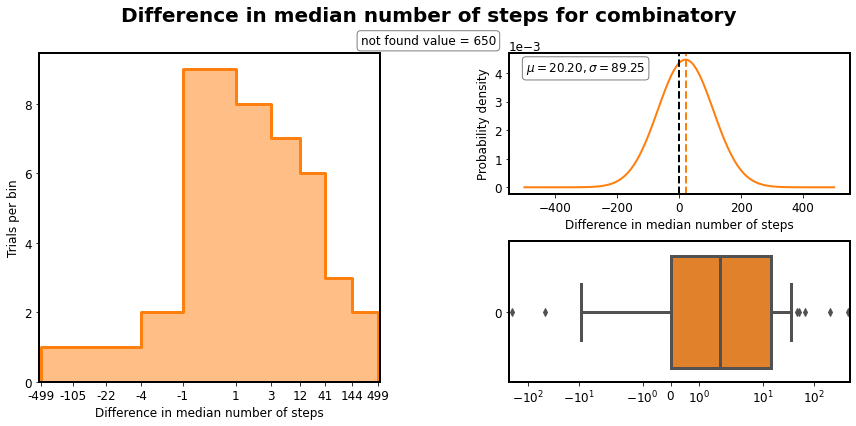

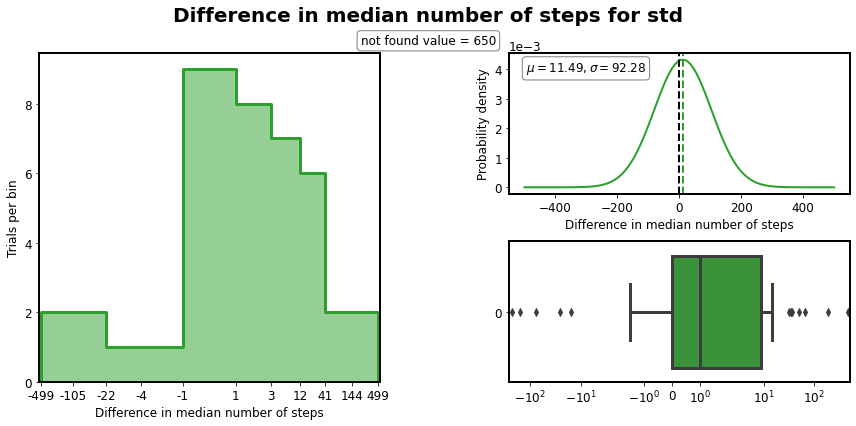

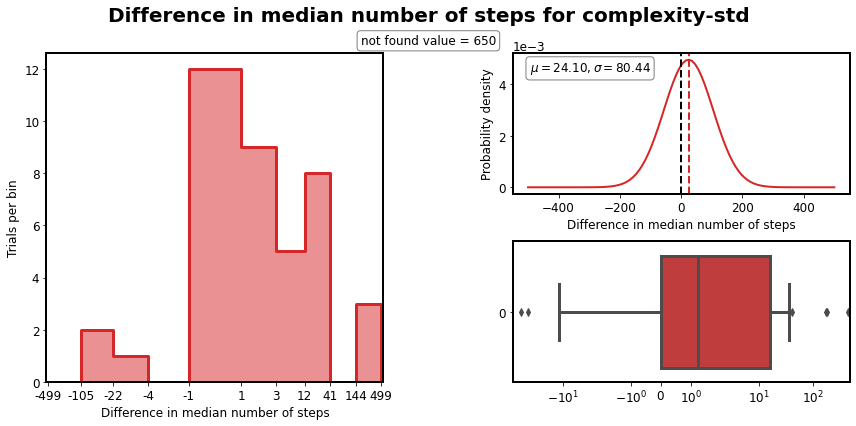

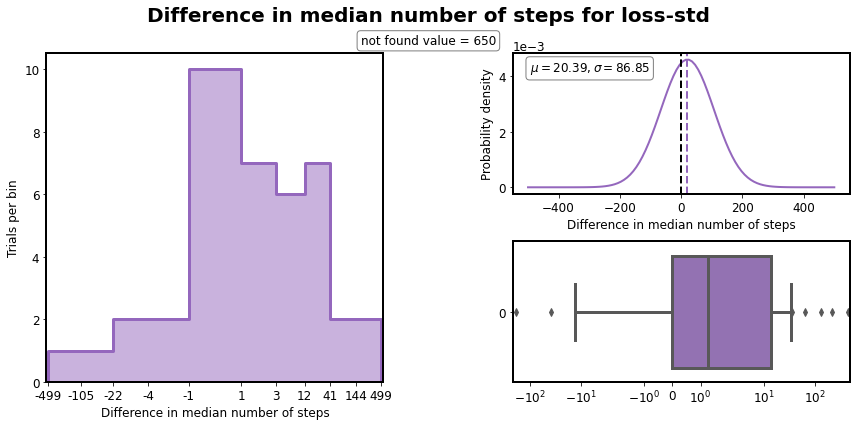

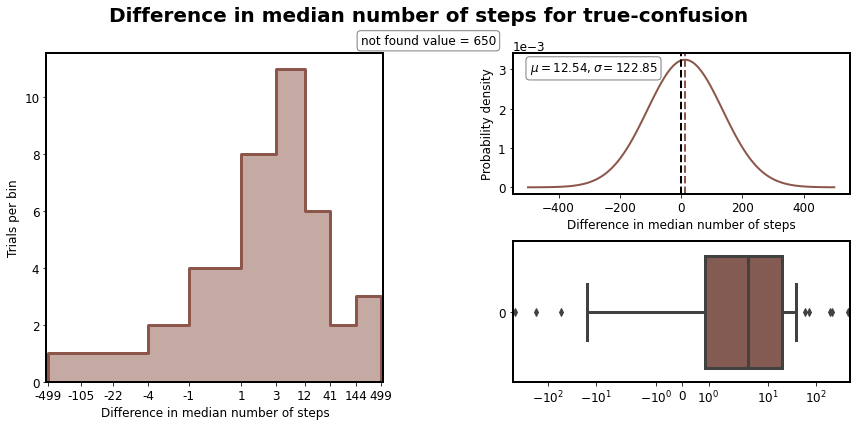

In [72]:
difference_plot_each(num=10, xmin=-500, xmax=500, not_found_num = 650)